In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import cm
import matplotlib as mpl


pointsize = 35

plt.style.use("seaborn-bright")

# Functions and labels

def myRMS(resid):
    return np.sqrt(np.mean(resid**2))

def ScatConv(sigx,f): # converts the standard deviation of scatter into natural space. 
    # MCMC algorithm calculates the natural log of the scatter, this function converts 
    # the standard deviation into natural space
    return np.abs(f)*np.abs(sigx) # source - https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Example_formulae

def plot_results(X,Y,Xerr,Yerr,xlabel,ylabel,color,f,lims,identity,fname): # Plotting routine 
    if type(color)!=type("test"):
        fig = plt.figure(figsize=[10,8])
    else:
        fig=plt.figure(figsize=[8,8])
    
    # plotting the results with errorbars
    plt.errorbar(X,Y,xerr=Xerr,yerr=Yerr,linestyle="none",elinewidth=.35,ecolor="black",barsabove=False)
    plt.scatter(X,Y,c=color,s=pointsize)
    
    # Plotting the identity line
    if identity==True:
        plt.plot([0,15],[0,15],c="black",linestyle='-',linewidth=2)
    
    # Plot the scatter of the relationship
    if f!=0:
        plt.plot([0,15],[0+f,15+f],c="red",linestyle='dashed',linewidth=1,label="$1\sigma$")
        plt.plot([0,15],[0-f,15-f],c="red",linestyle='dashed',linewidth=1)
        plt.plot([0,15],[0+2.5*f,15+2.5*f],c="blue",linestyle='dashed',linewidth=1,label = "$2.5\sigma$")
        plt.plot([0,15],[0-2.5*f,15-2.5*f],c="blue",linestyle='dashed',linewidth=1)
    
    # labels
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    
    # limits
    if lims!=0:
        plt.xlim(lims[0],lims[1])
        plt.ylim(lims[0],lims[1])
    
    #colorbar
    if type(color)!=type("test"):
        if np.min(color)>0: # if color array is entirely positive
            tmpmax = np.max(color)
            tmpmin = np.min(color)
        elif np.max<0: # if color array is entirely negative
            tmpmin = np.max(color)
            tmpmax = np.min(color)
        else: # if color array contains both pos and neg values
            tmpmax = np.max(np.abs(color))
            tmpmin = -np.max(np.abs(color))
        plt.colorbar()
        plt.clim(vmin=tmpmin,vmax=tmpmax)

    # file save
    if fname!=False:
        plt.savefig(fname+".png",dpi=300)
    plt.show()
    
def log_unc(f,sigf):
    logf = np.log10(f)
    sig_logf = np.abs(sigf/(np.log(10)*f))
    return sig_logf
    
def Fit_Model(obs,params): # returns the values based on the MCMC model - for use with 2-parameter model only
    observed = obs[0] # the observed measurement of the mass or LCO
    observed_measurements = obs[1:] # the measurements that inform the model
    model = np.dot(params[:2],observed_measurements)+params[2] # calculating the model measurement based on the MCMC parameters + galaxy observations
    resid = observed-model # calculating the expected-observed residual
    return model, resid # returning the model value, as well as the residual value

def Fit_Model2(arr,params): # a similar function to Fit_Model, but this time for the one parameter model  
    obs = arr[0]
    model = np.dot(arr[1],params[0])+params[1]
    resid=obs-model
    return model,resid

def product_Uncertainty(vec,vec_unc): # takes in two vectors, one of measurements + one of measurement uncertainties
    # returns the proppagated uncertainty assuming the variables are uncorrelated (i.e., covariance = 0)
    iden = 1
    su = 0
    for i in range(len(vec)):
        iden=iden*vec[i]
        su+=(vec_unc[i]/vec[i])**2
    return np.sqrt(su)*np.abs(iden)

def Err_linearComb(vec): # takes in a vector of measurement errors, returns the errors added in quadrature
    su=0
    for i in range(len(vec)):
        su+=vec[i]**2
    return np.sqrt(su)

def comb_unc(Arr,Arr2,Params,Params2):
    # calculate the uncertainties between the slopes (m_n) and their parameters (a_n)
    # Arr is an mxn-dimensional array of measurements, that are corresponded to the coefficients (params) of the linear equation
    # Arr2 is an mxn-dimensional array of measurement errors
    # Params is an array of coefficients, Params2 is the standard deviations of the coefficients
    
    # calculate the uncertainty for the coefficients
    m_unc = np.zeros([len(Arr)+1,len(Arr[0])])
    for i in range(len(Arr)):
        temp = np.zeros(len(Arr[i]))
        tmp = np.zeros(len(Arr[i]))
        temp[:] = Params[i]
        tmp[:] = Params2[i]
        m_unc[i] = product_Uncertainty([Arr[i],temp],[Arr2[i],tmp])
    # calculate the uncertainty for the intercept
    b_unc = np.zeros(len(Arr[0]))
    b_unc[:] = Params2[len(Arr)]
    # Plug into the Err_linearComb function
    m_unc[len(Arr)] = b_unc
    return Err_linearComb(m_unc)

BDecLabel = "$\log$(H\u03B1/H\u03B2)"
LCO10Label = "$\log(L_{CO_{1-0}})$ [K km s$^{-1}$ pc$^2$]"
LCO21Label = "$\log$($L_{CO_{2-1}}$)"
MDustLabel = "$\log$(M$_{Dust})$[M$_\odot$]"
MH2Label = "$\log$($M_{H_2})$[M$_\odot$]"
StarMassLabel = "$\log$(M$_{Star}$) [M$_\odot$]"
SFRLabel = "$\log$(SFR) [$M_\odot$ yr$^{-1}$]"
GasFracLabel = "$\log (f_{H_2})$"
N2HALabel = "$\log$(N$_2$/H\alpha)"
fitLabel = "a+b*$\log$(BD)+c*(i)"
fitLabel2 = "a+b*$\log$(BD)"

File io

In [187]:
dfJingle = pd.read_csv("JINGLEMASTERDEC19.csv")
dfJingle = dfJingle.drop(44) # this is a nan value for the dust measurement - why is this galaxy a nan?
dfJingle.reset_index(inplace=True)
del dfJingle['index']
del dfJingle['Unnamed: 0' ]
del dfJingle['Unnamed: 0.1' ]
del dfJingle['Unnamed: 0.1.1' ]
del dfJingle['Unnamed: 0.1.1.1']
del dfJingle['Unnamed: 0.1.1.1.1' ]
del dfJingle['Unnamed: 0.1.1.1.1.1']


xColdDF = pd.read_csv("xColdFilt.csv")
del xColdDF['Unnamed: 0']
del xColdDF['Unnamed: 0.1']
del xColdDF['Unnamed: 0.1.1']
xColdDF["LOGSFR_BEST"] = np.log10(xColdDF["SFR_BEST"])
xColdDF["LOGSFR_BEST_ERR"] = log_unc(xColdDF["SFR_BEST"],xColdDF["SFR_ERR"])
xColdDF["GasFrac_True"] = np.log10(10**(xColdDF["LOGMH2"])/(10**(xColdDF["MASS"])))

SDSSDF = pd.read_csv("../code 20 - refinements on 2D sampler/Sanity check/Sanitycheck2.csv")
del SDSSDF["index"]
del SDSSDF["level_0"]

In [185]:
# print(dfJingle.columns.values)
print(xColdDF.columns.values)
# print(SDSSDF.columns.values)

['ID' 'SAMPLE' 'AGCNR' 'SDSS' 'OBJID' 'SPECOBJID' 'PLATEID' 'MJD'
 'FIBERID' 'RA' 'DEC' 'Z_SDSS' 'LUMDIST' 'INCL' 'NUVR_GEXT' 'D25_G'
 'R50_R' 'R50KPC' 'R50_Z' 'R50_NUV' 'R50_NUV_ERR' 'R50_SFR' 'R50_SFR_ERR'
 'MASS' 'MASS_ERR' 'MUST' 'CINDX' 'SFR_SDSS' 'SFR_SED' 'SFR_BEST'
 'SFR_ERR' 'SFR_CASE' 'SFR_IR' 'SFR_IR_ERR' 'SSFR' 'DELTAMS_P10'
 'DELTAMS_S16' 'DELTAMS_W12' 'DELTAMS_W14' 'D4000' 'N2HA' 'O3HB' 'BALMER'
 'BALMER_ERR' 'AGNCLASS' 'Z_PP04_N2' 'Z_PP04_O3N2' 'Z_MZR' 'Z_FIBER'
 'HISRC' 'ZHI' 'W50COR' 'LOGMHI' 'LOGMHIMS' 'HICONF' 'GROUPID'
 'ENVIRONMENT' 'NGROUP' 'LOGMHALO' 'LOGRNORM' 'FLAG_CO' 'XCO' 'XCO_G12'
 'XCO_A16' 'XCO_A16_ERR' 'ICO' 'ICO_ERR' 'ICO_COR' 'ICO_COR_ERR' 'F_RECOV'
 'LCO' 'LCO_ERR' 'LCO_COR' 'LCO_COR_ERR' 'RMS_CO' 'SN_CO' 'WCO' 'WCO_FLAG'
 'Z_CO' 'WCO_TFR' 'WCO_TFR_ERR' 'WCO_TFR_FLAG' 'LOGMH2' 'LOGMH2_ERR'
 'LIMLOGMH2' 'MH2_ERR' 'LOGMH2MS' 'LOGRMOL' 'FLAGRMOL' 'FLAG_CO21' 'ICO21'
 'ICO21_ERR' 'ICO21_COR' 'LCO21' 'LCO21_ERR' 'LCO21_COR' 'RMS_CO21'
 'SN_CO21' 'WCO21' 'W

Loading in parameters

In [188]:
gasParams = np.array([4.45,-0.00480,6.42358,0.35569]) # m1, m2, b, f - derived from MCMC
gasParams2 = np.array([np.mean([0.42903,0.42864]),np.mean([0.00206,0.00205]),np.mean([0.26913,0.26863]),np.mean([0.02372,0.02282])]) # std dev of m1, m2, b, and f - derived from MCMC
gasArr = np.array([xColdDF["LOGMH2"],xColdDF["BALMER"],xColdDF["INCL"]]) #  MH2, BD, i
gasArr2 = np.array([xColdDF["LOGMH2_ERR"],xColdDF["BALMER_ERR"],0]) #  MH2, BD, i measurement error
xColdDF["GasModel"], xColdDF["GasResid"] = Fit_Model(gasArr,gasParams)
xColdDF["GasFrac_MCMC_2"] = np.log10((10**(xColdDF["GasModel"]))/(10**(xColdDF["MASS"])))

LCOParams = np.array([6.16381, -0.00732, 4.7963,0.42894]) # m1, m2, b, f - derived from MCMC
LCOParams2 = np.array([np.mean([0.51396,0.51361]),0.00247,np.mean([0.32266,0.32219]),np.mean([0.02876,0.02772])]) # std dev of m1, m2, b, and f - derived from MCMC
LCOArr = np.array([xColdDF["LOGLCO"],xColdDF["BALMER"],xColdDF["INCL"]]) # LCO, BD, i
LCOArr2 = np.array([xColdDF["LOGLCO_ERR"],xColdDF["BALMER_ERR"],0]) #  LCO, BD, i measurement error
xColdDF["LCOModel"], xColdDF["LCOResid"] = Fit_Model(LCOArr,LCOParams)

DustParams = np.array([2.71802,-0.00251,6.21713,0.28188]) # m1, m2, b, f - derived from MCMC
DustParams2 = np.array([np.mean([0.30648,0.30619]),np.mean([0.00164]),np.mean([0.19867,0.19847]),np.mean([0.01946,0.01866])]) # std dev of m1, m2, b, and f - derived from MCMC
DustArr = np.array([dfJingle["logMDust"],dfJingle["MPA LBdec"],dfJingle["INCL"]]) # Dust, BD, i
DustArr2 = np.array([(dfJingle["logMDust lowerr"],dfJingle["logMDust uperr"]),dfJingle["MPA LBdec err"],0]) # Dust, BD, i measurement error
dfJingle["DustModel"], dfJingle["DustResid"] = Fit_Model(DustArr,DustParams)

Calculating combined uncertainties

In [5]:
comb_unc_dust = comb_unc(DustArr[1:3],DustArr2[1:3],DustParams,DustParams2)

comb_unc_gas = comb_unc(gasArr[1:3],gasArr2[1:3],gasParams,gasParams2)

comb_unc_LCO = comb_unc(LCOArr[1:3],LCOArr2[1:3],LCOParams,LCOParams2)

LCO results

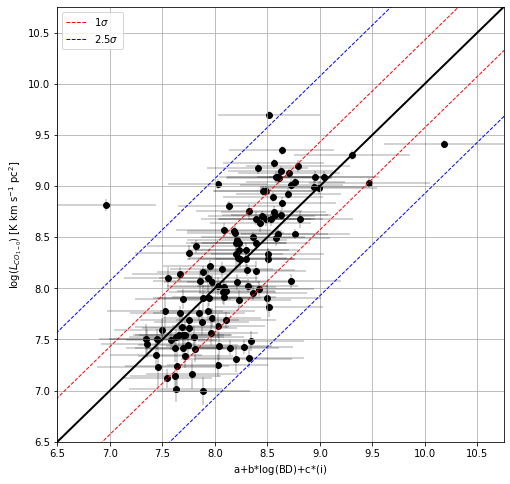

In [6]:
plot_results(LCOModel,LCOArr[0],comb_unc_LCO,LCOArr2[0],fitLabel,LCO10Label,"black",LCOParams[3],[6.5,10.75],True,"LCO_3param_comp") # plot the LCO plot 

Gas results

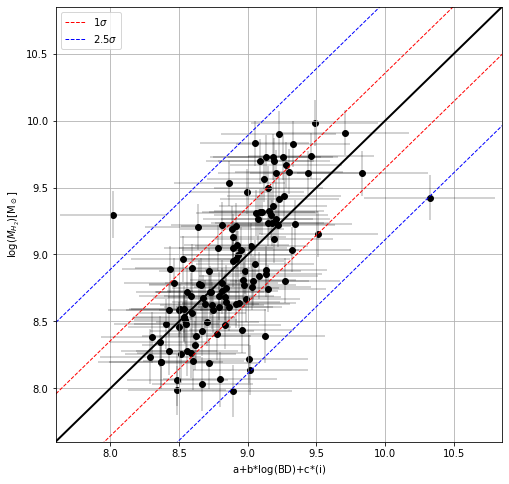

In [7]:
plot_results(GasModel,gasArr[0],comb_unc_gas,gasArr2[0],fitLabel,MH2Label,"black",gasParams[3],[7.6,10.85],True,"MH2_3param_comp") # plot the gas plot 

Dust results

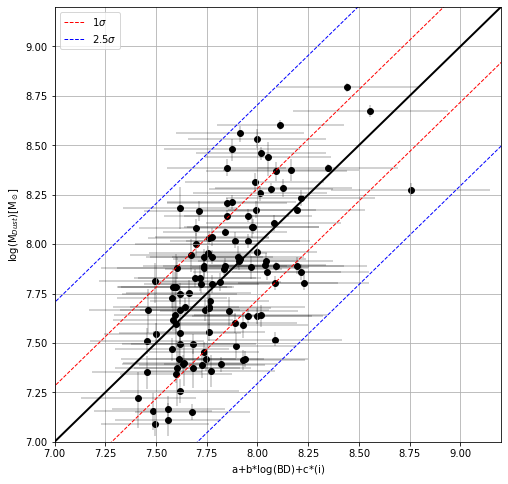

In [8]:
plot_results(DustModel,DustArr[0],comb_unc_dust,DustArr2[0],fitLabel,MDustLabel,"black",DustParams[3],[7,9.2],True,"Dust_3param_comp") # plot the dust plot 

In [9]:
# print(DustParams,DustParams2)

In [10]:
ScatConv(0.06367,0.3627)

0.023093109000000004

In [11]:
print("RMS residuals of Balmer decrement and inclination calibration with Gas: "+str(myRMS(GasResid)))
print("RMS residuals of Balmer decrement and inclination calibration with log(L_{CO}): "+str(myRMS(LCOResid)))
print("RMS residuals of Balmer decrement and inclination calibration with Dust: "+str(myRMS(DustResid)))

RMS residuals of Balmer decrement and inclination calibration with Gas: 0.3598375800672652
RMS residuals of Balmer decrement and inclination calibration with log(L_{CO}): 0.4370282674845384
RMS residuals of Balmer decrement and inclination calibration with Dust: 0.28181612809468476


## Revisiting the one-parameter model + re-visualization (for posterity)

In [12]:
twogasParams = np.array([4.29199,6.27114,0.36270]) # m1, b, f - derived from MCMC
twogasParams2 = np.array([np.mean([0.42834,0.42799]),np.mean([0.26347,0.26366]),np.mean([0.023,0.024])]) # std dev of m1, b, and f - derived from MCMC
twogasArr = np.array([xColdDF["LOGMH2"],xColdDF["BALMER"]]) #  MH2, BD
twogasArr2 = np.array([xColdDF["LOGMH2_ERR"],xColdDF["BALMER_ERR"]]) #  MH2, BD measurement error
twoGasModel, twoGasResid = Fit_Model2(twogasArr,twogasParams)

twoLCOParams = np.array([5.92710, 4.56102,0.44367]) # m1, b, f - derived from MCMC
twoLCOParams2 = np.array([np.mean([0.52106,0.52036]),np.mean([0.32052,0.32097]),np.mean([0.02947,0.02835])]) # std dev of m1, b, and f - derived from MCMC
twoLCOArr = np.array([xColdDF["LOGLCO"],xColdDF["BALMER"]]) # LCO, BD
twoLCOArr2 = np.array([xColdDF["LOGLCO_ERR"],xColdDF["BALMER_ERR"]]) #  LCO, BD measurement error
twoLCOModel, twoLCOResid = Fit_Model2(twoLCOArr,twoLCOParams)

twoDustParams = np.array([2.59925,6.14902,0.28363]) # m1, b, f - derived from MCMC
twoDustParams2 = np.array([np.mean([0.29808,0.29768]),np.mean([0.19437,0.19465]),np.mean([0.01949,0.01871])]) # std dev of m1, b, and f - derived from MCMC
twoDustArr = np.array([dfJingle["logMDust"],dfJingle["MPA LBdec"]]) # Dust, BD
twoDustArr2 = np.array([(dfJingle["logMDust lowerr"],dfJingle["logMDust uperr"]),dfJingle["MPA LBdec err"]]) # Dust, BD, measurement error
twoDustModel, twoDustResid = Fit_Model2(twoDustArr,twoDustParams)

In [13]:
print(myRMS(twoDustResid))
print(myRMS(twoLCOResid))
print(myRMS(twoGasResid))

0.2846859022516066
0.45051752792941957
0.3669137624695721


Calculating combined uncertainties for the one-parameter model

In [14]:
def comb_unc2(Arr,Arr2,Params,Params2): # for use with one parameter model only
    # calculate the uncertainties between the slopes (m_n) and their parameters (a_n)
    # Arr is an 2xn-dimensional array of measurements, that are corresponded to the coefficients (params) of the linear equation
    # Arr2 is an 2xn-dimensional array of measurement errors
    # Params is an array of coefficients, Params2 is the standard deviations of the coefficients
    
    
    temp = np.zeros(len(Arr))
    tmp = np.zeros(len(Arr))
    temp[:] = Params[0]
    tmp[:] = Params2[0]
    
    # calculate the uncertainty for the coefficients
    m_unc = np.zeros([2,len(Arr)])
    
    tamp = product_Uncertainty(np.array([Arr,temp]),np.array([Arr2,tmp]))
#     print(tamp)
    m_unc[0] = tamp
    
    # calculate the uncertainty for the intercept
    b_unc = np.zeros(len(Arr))
    b_unc[:] = Params2[-1]
    m_unc[1] = b_unc
    
    # Plug into the Err_linearComb function
    return Err_linearComb(m_unc)

In [15]:
comb_unc_dust2 = comb_unc2(twoDustArr[1],twoDustArr2[1],twoDustParams[0:2],twoDustParams2[0:2])

comb_unc_LCO2 = comb_unc2(twoLCOArr[1],twoLCOArr2[1],twoLCOParams[0:2],twoLCOParams2[0:2])

comb_unc_gas2 = comb_unc2(twogasArr[1],twogasArr2[1],twogasParams[0:2],twogasParams2[0:2])

Results from one-parameter fits

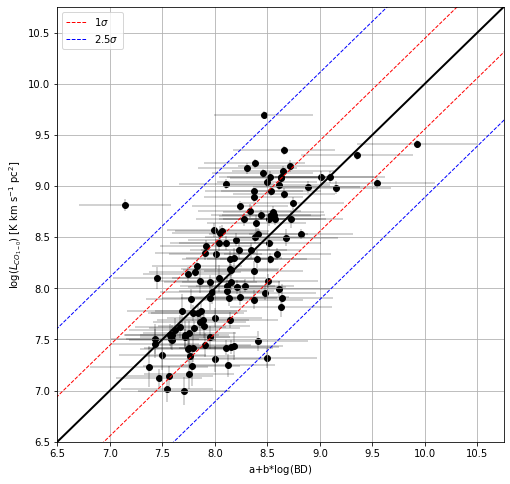

In [16]:
plot_results(twoLCOModel,twoLCOArr[0],comb_unc_LCO2,twoLCOArr2[0],fitLabel2,LCO10Label,"black",twoLCOParams[2],[6.5,10.75],True,"LCO_oneparam_comp") # plot the LCO plot 

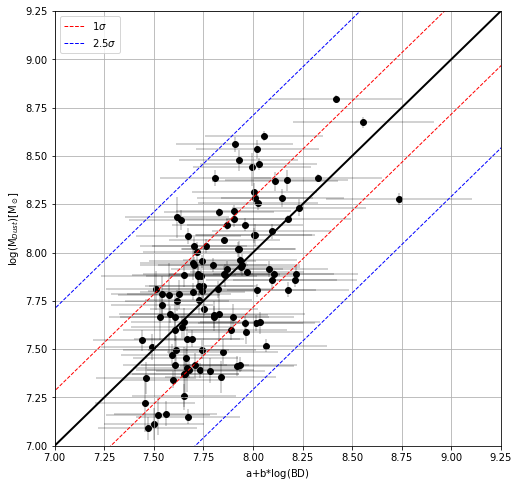

In [17]:
plot_results(twoDustModel,twoDustArr[0],comb_unc_dust2,twoDustArr2[0],fitLabel2,MDustLabel,"black",twoDustParams[2],[7,9.25],True,"Dust_oneparam_comp") # plot the Dust plot 

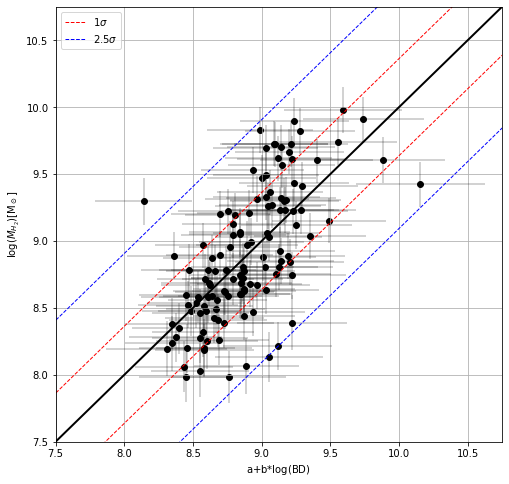

In [18]:
plot_results(twoGasModel,twogasArr[0],comb_unc_gas2,twogasArr2[0],fitLabel2,MH2Label,"black",twogasParams[2],[7.5,10.75],True,"Gas_oneparam_comp") # plot the gas plot 

## Detailing SFR-M* plane with 3-param calibrations

In [19]:
def SFR_plot(x,y,Xerr,Yerr,xlabel,ylabel,xlim,ylim,color,fname):
    fig,ax = plt.subplots()
    fig=plt.figure(figsize=[10,8])
    
    ax.scatter(x,y,c=color,s=pointsize)
    ax.errorbar(x,y,xerr=Xerr,yerr=Yerr,linestyle="none",elinewidth=.35,ecolor="black",barsabove=False)
    
    ax.grid()
    
    ax.xlim(xlim[0],xlim[1])
    ax.xlim(ylim[0],ylim[1])
    
    fig.colorbar



No handles with labels found to put in legend.


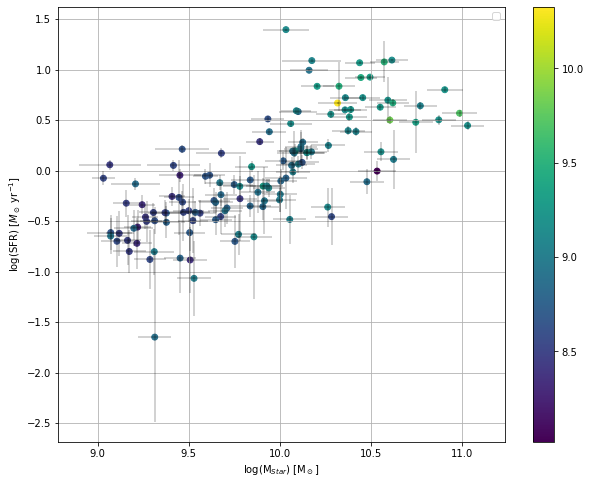

In [20]:
plot_results(xColdDF["MASS"],np.log10(xColdDF["SFR_BEST"]),xColdDF["MASS_ERR"],log_unc(xColdDF["SFR_BEST"],xColdDF["SFR_ERR"]),StarMassLabel,SFRLabel,GasModel,0,0,False,"SFR_diag_xCOLD_3param_Gas")

No handles with labels found to put in legend.


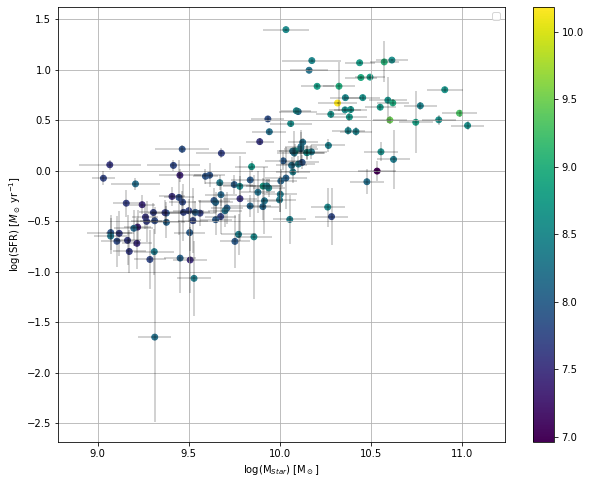

In [21]:
plot_results(xColdDF["MASS"],np.log10(xColdDF["SFR_BEST"]),xColdDF["MASS_ERR"],log_unc(xColdDF["SFR_BEST"],xColdDF["SFR_ERR"]),StarMassLabel,SFRLabel,LCOModel,0,0,False,"SFR_diag_xCOLD_3param_LCO")

No handles with labels found to put in legend.


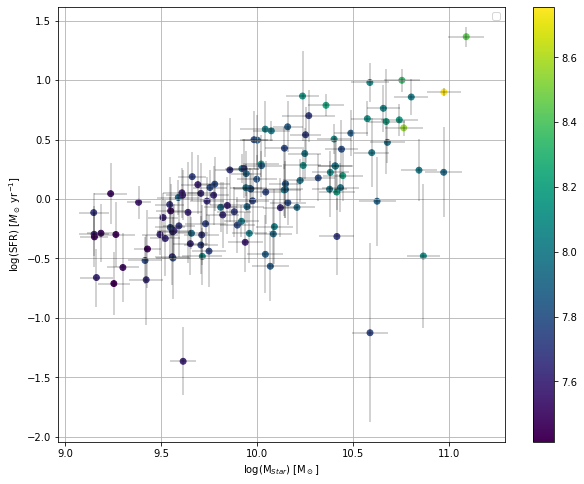

In [22]:
plot_results(dfJingle["LOGMSTAR_MPAJHU"],dfJingle["LOGSFR_MPAJHU"],dfJingle["LOGMSTAR_MPAJHU_ERR"],dfJingle["LOGSFR_MPAJHU_ERR"],StarMassLabel,SFRLabel,DustModel,0,0,False,"SFR_diag_xCOLD_3param_Dust")

# Contour plots with SDSS data comparing to the calibrations of xCOLD GASS and JINGLE results

In [207]:
sns.set_theme(style="darkgrid")

def contourScat(contx,conty,scatx,scaty,scatColor,scatColorlab,xlab,ylab,contlab,scatlab,legend=True,save=False,fname=None,xlims=None,ylims=None):
    
    f, ax = plt.subplots(figsize=(6, 9)) # initializing figure
    
    scatplot = plt.scatter(x=scatx,y=scaty,c=scatColor,label=scatlab,zorder=2) # Scatter
    sns.kdeplot(x=contx,y=conty,color="black",ax=ax,levels=15,alpha=0.8,label=contlab,zorder=1,fill=True) # Contour
    
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
    if legend==True:
        plt.legend(loc="best")
    
    scatplot.figure.colorbar(scatplot,ax=ax,orientation="horizontal", pad=0.15,cmap="spectral").set_label(scatColorlab)
    
    if type(xlims)!=type(None):
        plt.xlim(xlims[0],xlims[1])
    if type(ylims)!=type(None):
        plt.ylim(ylims[0],ylims[1])
    
#     plt.grid()
    
    if save==True:
        plt.savefig(fname+".png",dpi=180)

    plt.show()

### Dust with contours from SDSS

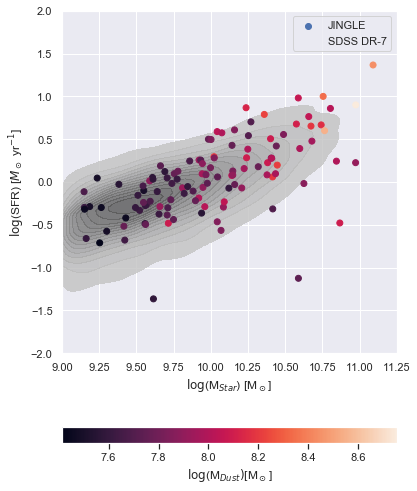

In [215]:
contourScat(SDSSDF["StarMass"],SDSSDF["SFR"],dfJingle["LOGMSTAR_MPAJHU"],dfJingle["LOGSFR_MPAJHU"],dfJingle["DustModel"],MDustLabel,StarMassLabel,SFRLabel,"SDSS DR-7","JINGLE",xlims=[9,11.25],ylims=[-2,2],save=True,fname="DustContour")

### $M_{H_2}$ with contours from SDSS

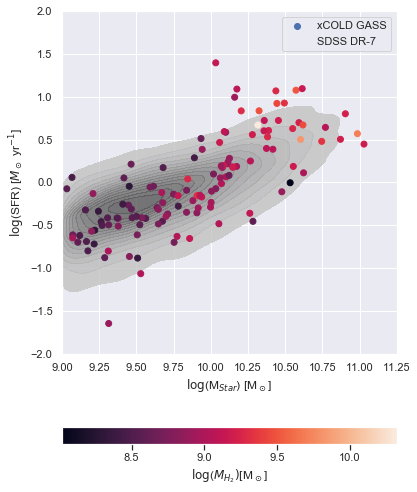

In [216]:
contourScat(SDSSDF["StarMass"],SDSSDF["SFR"],xColdDF["MASS"],xColdDF["LOGSFR_BEST"],xColdDF["GasModel"],MH2Label,StarMassLabel,SFRLabel,"SDSS DR-7","xCOLD GASS",xlims=[9,11.25],ylims=[-2,2],save=True,fname="MH2Contour")

### $\log(f_{H_2})$ with contours from SDSS

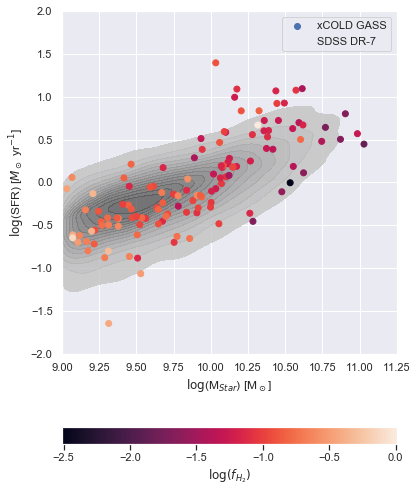

In [218]:
contourScat(SDSSDF["StarMass"],SDSSDF["SFR"],xColdDF["MASS"],xColdDF["LOGSFR_BEST"],xColdDF["GasFrac_MCMC_2"],GasFracLabel,StarMassLabel,SFRLabel,"SDSS DR-7","xCOLD GASS",xlims=[9,11.25],ylims=[-2,2],save=True,fname="GasFracContour")

### $\log (L_{CO_{1\rightarrow 0}})$ with contours from SDSS

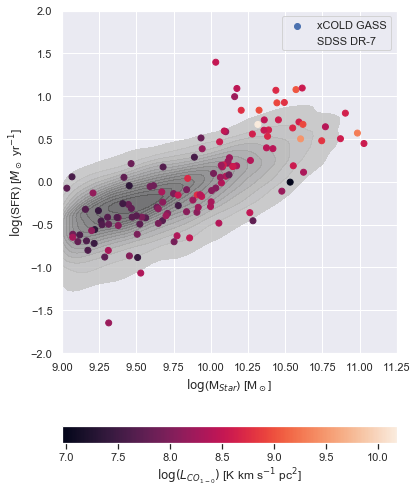

In [217]:
contourScat(SDSSDF["StarMass"],SDSSDF["SFR"],xColdDF["MASS"],xColdDF["LOGSFR_BEST"],xColdDF["LCOModel"],LCO10Label,StarMassLabel,SFRLabel,"SDSS DR-7","xCOLD GASS",xlims=[9,11.25],ylims=[-2,2],save=True,fname="LCOContour")